In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import Modules
import ast
from collections import Counter
import numpy as np
from pandas_profiling import ProfileReport
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn.datasets
from scipy import spatial
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.patches as patches
import mplcyberpunk
import seaborn as sns
from typing import List, Dict, Callable

%matplotlib inline
# plt.style.use('ggplot')
plt.style.use("cyberpunk")

In [3]:
# Import Custom Modules
from src.helpers import *

In [4]:
# Import Data
movies = pd.read_csv('cleaned_data/movies.csv')
users = pd.read_csv('cleaned_data/users.csv')
ratings = pd.read_csv('cleaned_data/ratings.csv')

In [5]:
# Import Movie Meta Data
movie_meta = pd.read_csv('data/movies_metadata.csv', low_memory=False)

## Run Pandas Profiling on Movies Meta

In [6]:
# Run Profiling about Movie Metadata
profile = ProfileReport(movie_meta, title="Movie Metadata Profiling Report", explorative=True)

# Store Profile in 'cleaned_data' folder
# profile.to_file("cleaned_data/movie_meta_profile.html")

In [7]:
movie_meta.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


## Find columns to keep

In [8]:
# Drop Columns with High Missing Value counts
movie_meta.drop(columns=['belongs_to_collection', 'budget', 'homepage', 'tagline', 'video', 'poster_path', 'status', 'release_date', 
                         'revenue', 'runtime', 'spoken_languages', 'original_title', 'id', 'imdb_id', 'production_countries', 'genres', 'original_language'], 
                inplace=True)

In [9]:
# movie_meta['overview']

## Clean Features

In [10]:
# Clean Production Companies
movie_meta['production_companies'].fillna('[]', inplace=True)
movie_meta['production_companies'] = movie_meta['production_companies'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: x[0]['name'] if x else '')

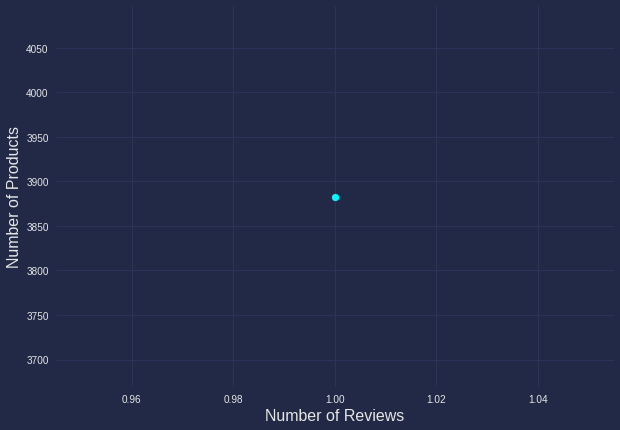

In [11]:
movies_w_n_reviews = movies['movie_id'].value_counts().value_counts()
plt.figure(figsize = (10,7))
plt.scatter( movies_w_n_reviews.index, movies_w_n_reviews)
plt.xlabel("Number of Reviews", fontsize = 16)
plt.ylabel("Number of Products", fontsize = 16);

## Merge Movie Data to Visualize Corr

In [12]:
# Create Feature to merge on
movies['title'] = movies['movie_title'].apply(lambda x: x.partition("(")[0].strip())

movies_full = movies.copy().merge(movie_meta.copy(), how='inner').drop(columns='title')

In [13]:
movies_full.corr()

,movie_id,year,vote_average,vote_count
movie_id,1.000000,0.005636,-0.009674,-0.054607
year,0.005636,1.000000,-0.031067,-0.008760
vote_average,-0.009674,-0.031067,1.000000,0.228825
vote_count,-0.054607,-0.008760,0.228825,1.000000


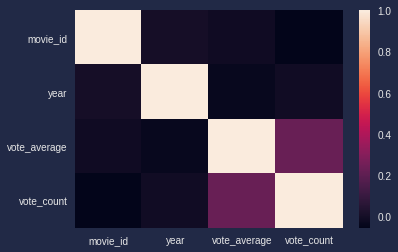

In [14]:
sns.heatmap(movies_full.corr())

## Use PySpark Library for ALS

In [62]:
import pyspark as ps
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

spark = SparkSession.builder.getOrCreate()
ratings = spark.createDataFrame(pd.read_csv('cleaned_data/ratings.csv'))

train, test = ratings.randomSplit([0.8, 0.2])

als = ALS(userCol='user',
         itemCol='movie',
         ratingCol='rating',
         nonnegative=True)

In [63]:
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 11, 12, 13, 14]) \
            .addGrid(als.maxIter, [15, 15, 18, 19, 20]) \
            .addGrid(als.regParam, [0.1, 0.2, .17, .18, .19]) \
            .build()

In [64]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

In [65]:
cv = CrossValidator(estimator=als,
                    estimatorParamMaps=param_grid,
                    evaluator=evaluator,
                    numFolds=5) 

In [ ]:
model = cv.fit(train)

In [ ]:
best_model = model.bestModel

In [ ]:
predictions = best_model.transform(test)
rmse = evaluator.evaluate(predictions)

In [ ]:
predictions.show()

In [ ]:
test_df = pd.read_csv('data/fake_testing.csv')

In [ ]:
test_df['rating'] = test_df['actualrating']

In [ ]:
test_df.drop(columns='actualrating', inplace=True)

In [ ]:
test_ratings = spark.createDataFrame(test_df)

In [ ]:
predictions = best_model.transform(test_ratings)
rmse = evaluator.evaluate(predictions)

In [ ]:
rmse

In [ ]:
test_df.shape

In [ ]:
predictions.show()

In [ ]:
x = predictions.toPandas()
x.shape

In [ ]:
x[pd.isnull(x['prediction'])]

## Item Item Collaborative Filtering

## Use Surprise Library for ALS

In [ ]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
 
    
    
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user','movie','rating']], reader)

trainset, testset = train_test_split(data, test_size=.25)

algorithm = SVD()
algorithm.fit(trainset)

predictions = algorithm.test(testset)

In [ ]:
accuracy.rmse(predictions)

In [ ]:
user_id = 7010

In [ ]:
predicted_ratings = pred_user_rating(user_id)
pdf = pd.DataFrame(predicted_ratings, columns = ['movies','ratings'])
pdf.sort_values('ratings', ascending=False, inplace=True)  
pdf.set_index('movies', inplace=True)
pdf.head(10)